In [1]:
%%bash
pip install cmweather > /dev/null
pip install pillow > /dev/null
pip install imageio[pyav] > /dev/null
pip install cartopy > /dev/null
pip install xarray > /dev/null

# Chapter 8.1 - Introduction to Machine Learning

[Machine learning](https://en.wikipedia.org/wiki/Machine_learning) can be defined as the study and implementation of algorithms that learn data-driven patterns to inform predictions or decisions. This is in contrast to so-called [expert systems](https://en.wikipedia.org/wiki/Expert_system) that are given specific rules to follow.

Severe weather forecasting can be used to demonstrate the dichotomy:

1. Expert system: Forecast of severe weather if CAPE > 1000 and shear > 40 kts.

2. Machine learning: Use severe weather reports and the associated environments to determine thresholds of CAPE and shear based on those example days.

Even with this simple case, you could think of many caveats:

1. How do you define a severe weather report?
2. How do you define where the report takes place?
3. Do you apply quality control to the report data?
4. What is the source of the report data?
5. Are CAPE and shear enough to identify severe risk?
6. What are the sources for CAPE and shear?
7. What is the resolution of the environmental data?
8. Etc., etc., etc.

You can surmise that your domain knowledge is still extremely valuable and allows you to frame the problems correctly, identify data quality issues, and effectively evaluate the results of the model.

This topic is expansive, but we will cover some important high-level issues in this chapter.

**Example data**

We will be using a storm morphology classification dataset based on [Haberlie and Ashley (2018)](https://journals.ametsoc.org/view/journals/apme/57/7/jamc-d-17-0293.1.xml).

In [2]:
%%bash
mkdir storm_mode
cd storm_mode
wget -nc -q https://raw.githubusercontent.com/ahaberlie/unidata-workshop-2018/refs/heads/master/workshop/data/training/sample_train_data.csv
wget -nc -q https://raw.githubusercontent.com/ahaberlie/unidata-workshop-2018/refs/heads/master/workshop/data/training/sample_test_data.csv
wget -nc -q https://nimbus.niu.edu/courses/EAE483/BREF_090508_1300.png

In [3]:
import pandas as pd

df = pd.read_csv("storm_mode/sample_train_data.csv")

numeric_cols = df.select_dtypes(include="number").columns.tolist()
numeric_cols.remove('index')
numeric_cols.remove('label')
numeric_cols.remove('label1')

print(len(numeric_cols), "dimensions")
print(len(df), "observations")
df.head()

19 dimensions
399 observations


,datetime,index,filename,mean_intensity,solidity,intensity_variance,intense_convection_ratio,convection_stratiform_ratio,area,convection_area,...,intense_stratiform_ratio,major_axis_length,label,minor_major_ratio,xmax,xmin,ymax,ymin,label1,label_name
0,2008-07-06 06:25:00,1292,extracted/mcs_files/mcs_BREF_080706_0625_000.png,28.275568,0.643510,83.110615,0.308452,0.172538,21120,3644,...,0.053220,359.772021,0,0.260919,1966,1828,290,145,1,MCS
1,2013-06-09 19:35:00,1772,extracted/mcs_files/mcs_BREF_130609_1935_001.png,31.102197,0.458959,70.989211,0.201437,0.220508,58084,12808,...,0.044418,501.497502,0,0.435192,1948,1679,1412,1199,1,MCS
2,2010-08-20 03:10:00,1552,extracted/mcs_files/mcs_BREF_100820_0310_001.png,31.347850,0.559617,89.086667,0.230869,0.277488,22228,6168,...,0.064063,256.749168,0,0.595245,2704,2583,1058,948,1,MCS
3,2011-06-20 10:05:00,1592,extracted/mcs_files/mcs_BREF_110620_1005_002.png,26.587559,0.287222,55.918631,0.246973,0.081171,40704,3304,...,0.020047,524.874712,0,0.455835,1448,1147,847,669,1,MCS
4,2007-06-18 22:35:00,1110,extracted/mcs_files/mcs_BREF_070618_2235_000.png,30.214721,0.597247,60.598419,0.181799,0.168044,110376,18548,...,0.030550,789.889039,0,0.275361,2238,1915,610,280,1,MCS


### Chapter 8.1.1 - Unsupervised learning

**Clustering**

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is the process of sorting data into groups by minimizing within-group variability and maximizing between-group variability. Examples can include animal taxonomy (https://en.wikipedia.org/wiki/Taxonomy_(biology)) or even [the closest minor league team to your county](https://www.caliper.com/featured-maps/maptitude-closest-major-league-and-minor-league-baseball.html).

This process is considered an ["unsupervised learning"](https://en.wikipedia.org/wiki/Unsupervised_learning) approach because the expert or user do not define the clusters (or labels, etc.). While there are some knobs to turn on the clustering models before the sorting process begins, the rest of the process is data driven.

We can use the storm mode dataset to quickly examine potential clusters based on their variables.

*Your turn*: Find the best combination of two variables that can be used to organize the data into groups that are similar within the group and different from other groups. What thresholds for each variabile would you choose? Based on these thresholds, what can you say about each class?

In [4]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

x_dd = widgets.Dropdown(
    options=numeric_cols,
    value="mean_intensity",
    description="X:"
)
y_dd = widgets.Dropdown(
    options=numeric_cols,
    value="major_axis_length",
    description="Y:")

def plot_scatter(x, y):
    fig, ax = plt.subplots(figsize=(7, 5))

    for name, g in df.groupby("label_name"):
        ax.scatter(g[x], g[y], label=str(name))

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f"{y} vs {x} by label_name")

    ax.legend(loc="upper left")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()

ui = widgets.HBox([x_dd, y_dd])
out = widgets.interactive_output(
    plot_scatter,
     {"x": x_dd, "y": y_dd})

display(ui, out)


Output()

**Dimensionality Reduction**

[Dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) is another unsupervised approach that can determine, based on the data, what variables (or combinations of variables) are most likely to help contribute to accurate machine learning predictions. This addresses the issue of the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)--specifically, how data with many dimensions (i.e., variables) require an attendant increase in observations.

Consider the problem of observing basic meteorological variables. On Earth's surface, the 2D sampling in the United States is relatively good. However, if you consider the vertical dimension (height), the dense observational network becomes relatively sparse.

**A helpful analogy in meteorology**

If you have 10 observations within a 100 km$^{2}$ region, you have a density of 0.1 observations per km$^{2}$. However, if you incorporate height (say 10 km), you have 0.01 observations per km$^{3}$. We address this issue in meteorology by determining the most *important* parts of the 3D space that describe the *most* variability. For example, surface observations are powerful because they are related to many atmospheric processes:

1. temperature tendency at the surface is related to insolation, cloud cover, advection, mixing, etc.

2. pressure tendency at the surface is related to upper-level mass convergence/divergence, vertical heating/cooling, mesoscale dynamics, etc.

We might also choose to focus on specific levels of interest (850 hPa for inversions and moisture transport; 500 hPa for trough/ridge identification; 250 hPa for jet structures).

*Think about this*: What meteorological variables or calculations "simplify" the 3D column?

**How that relates to our data**

While the "spatial sparsity" of the above example is not exactly 1-to-1 with sparsity in variable dimensions, we can use it to understand issues in "real world" machine learning datasets. For example, in the above DataFrame, we have 20 variables (20 dimensions) and 399 rows (observations).

While nearly 400 observations seems good, we may have issues with undersampling parts of the [parameter space](https://en.wikipedia.org/wiki/Parameter_space). If we identify correlated variables, for example, we could potentially reduce the dimensionality without limiting our ability to perform machine learning tasks.

*Your turn*: Identify highly correlated variables in the previous example. How might you combine the variables in a way that makes physical/meteorological sense?

### Chapter 8.1.2 - Supervised learning

**Regression**

[Regression analysis](https://en.wikipedia.org/wiki/Regression_analysis) is a specific type of machine learning that identifies [correlations](https://en.wikipedia.org/wiki/Correlation) (if any) between two variables.

Here are some examples of 2D correlations below, where pairs of x-axis and y-axis variable values are plotted in a scatterplot. A regression analysis would attempt to develop a statistical relationship between the variables. For example, in linear regression, you could develop an inference about the data that allows you to say: "for every increase in 1 unit for the x variable, we see an increase of 1*slope units for the y variable". The [correlation coefficient](https://en.wikipedia.org/wiki/Correlation_coefficient) (number above each subplot below) generated by this process could then tell you the strength and sign of the correlation.   

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg"></img>

*Your turn*: Examine the correlated variables below and select which line would best represent a "best fit" line. After selection, what is your interpretation of the line's slope and what can that tell you about the relationship between the two variables?

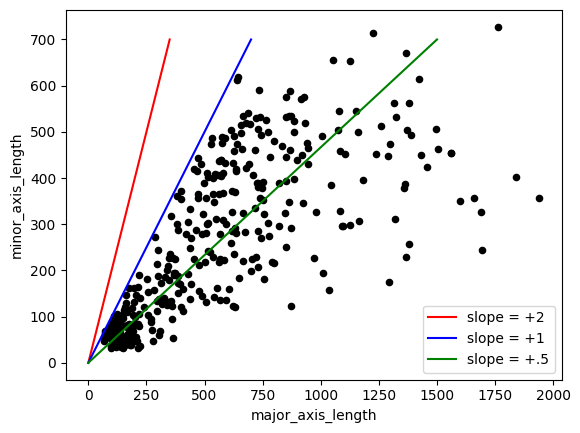

In [5]:
ax = plt.subplot(1, 1, 1)

df.plot(kind='scatter', color='k', x='major_axis_length', y='minor_axis_length', ax=ax)

ax.plot([0, 350], [0, 700], 'r-', label="slope = +2")
ax.plot([0, 700], [0, 700], 'b-', label="slope = +1")
ax.plot([0, 1500], [0, 700], 'g-', label="slope = +.5")

plt.legend()

**Classification**

[Classification](https://en.wikipedia.org/wiki/Statistical_classification) is the process of using a set of observations / variables to make a prediction, such as a classification decision (e.g., "MCS", "Tropical", etc.). One "supervised" version of this process requires an "expert" to examine observations and provide a "label". This was done for the data example used in this chapter already--specifically, variables were calculated to describe the visual attributes of certain [storm modes (NWS Training Module link)](https://training.weather.gov/wdtd/courses/woc/severe/storm-structures-hazards/storm-modes/understanding-sm/story_html5.html) in radar images. Below is an example of the original radar image that can be used to extract these predictor variables. Since the image is very large (1837 x 3661 pixels), dimensionality reduction was performed by finding basic statistics of regions in the image. The variables associated with the mesoscale convective system in the center of the image are as follows and are calculated using [regionprops](https://scikit-image.org/docs/0.25.x/api/skimage.measure.html#skimage.measure.regionprops) from scikit-image and converted to km or km$^{2}$ if needed. By focusing only on the region around the MCS (more on that in later chapters) and calculating attributes that *summarize* how the MCS "looks" in the image, we can reduce our dimensions from nearly 7 million to 14.

```
area:218,872
convex_area:343,384
eccentricity:0.7485591570667407
intense_area:8,852
convection_area:60,480
convection_stratiform_ratio:0.2763258891041339
intense_stratiform_ratio:0.04044372966848204
intense_convection_ratio:0.14636243386243386
mean_intensity:32.33643408019299
max_intensity:70
intensity_variance:71.06936629660673
major_axis_length:690.2774522580476
minor_axis_length:457.7008979107097
solidity:0.6373971996365585
```


(1837, 3661)


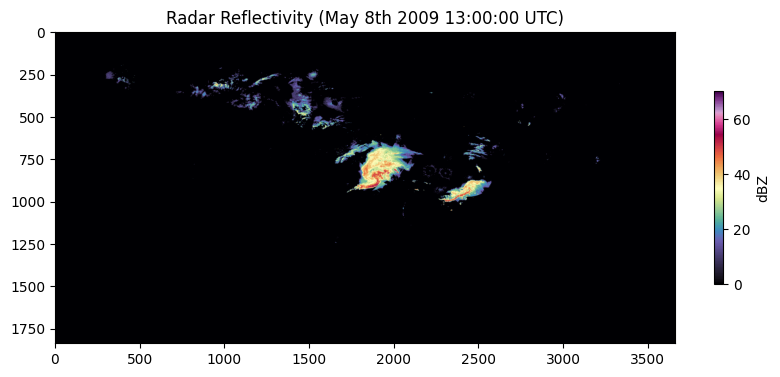

In [6]:
import cmweather
import numpy as np
from PIL import Image

plt.rcParams['figure.figsize'] = 10, 10

img = Image.open("storm_mode/BREF_090508_1300.png")
img = np.array(img)

print(img.shape)

plt.imshow(np.array(img) * 5, cmap='ChaseSpectral')
plt.title("Radar Reflectivity (May 8th 2009 13:00:00 UTC)")
cbar = plt.colorbar(shrink=0.25)
cbar.set_label("dBZ")

### Chapter 8.1.3 - Data Representation

There are some "new" terms you may encounter when learning about machine learning. We will discuss some of these terms and connect them back to comparable Geoscience terms when possible.


- *sample* / *example* / *observation* - one training instance
- *feature* - a single input variable in a sample
- *feature vector* - the complete set of variables for a sample
- *feature extraction* - the process of creating structured features from unstructured inputs (images, text, etc.)
- *feature engineering* - Designing new features using domain knowledge
- *target* / *label* - the output you want the model to predict using *feature vectors* from *samples*.
- *machine learning model* - the model of relationships between input *feature vectors* and output *targets*

*Your turn*: Based on the dataset above, identify the following.

1. Sample:
2. Feature:
3. Feature Vector:
4. Feature Extraction:
5. Feature Engineering:
6. Target:

**Feature Vector**

We can examine a *feature vector* from the examples above to see how it can be interpreted as a 1D signal. Change `row_number`.

What do you immediately notice about the variables?

In [7]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# If numeric_cols isn't defined yet, define it like this:
# numeric_cols = df.select_dtypes(include="number").columns.tolist()

plt.rcParams["figure.figsize"] = (23, 5)

nrows = len(df)

@interact(
    row_number1=widgets.IntSlider(value=50, min=0, max=nrows-1, step=1, description="row 1"),
    row_number2=widgets.IntSlider(value=300, min=0, max=nrows-1, step=1, description="row 2"),
)

def plot_two_rows(row_number1, row_number2):
    row1 = df.iloc[row_number1]
    row2 = df.iloc[row_number2]

    ax = plt.subplot()
    ax.plot(row1[numeric_cols].values, color="blue", ls="--", label=row1["label_name"])
    ax.plot(row2[numeric_cols].values, color="red",  ls="-",  label=row2["label_name"])
    ax.set_title("Signal for two samples")
    ax.legend()

    ax.set_xticks(range(len(numeric_cols)))
    ax.set_xticklabels(numeric_cols, rotation=45)
    ax.grid()


interactive(children=(IntSlider(value=50, description='row 1', max=398), IntSlider(value=300, description='row…

**Standardization**

We are trying to examine differences in the signal between classes. If you have a very large value (as seen above), that can draw the focus of a prediction model.

Instead, we can use the preprocessing capabilities of scikit-learn to make the signal less reliant on a few very large features. This can even plug in to `pandas`.

*Your Turn*: Find an example of each label by changing the row numbers. What do you notice about the z-score signal of the feature vector? Is this easier to interpret compared to the previous example? What are some ways that the standardization process might introduce bias? How do you interpet an "intense area" of over +5 for sample 30? Could you draw what the original radar image looked like for a sample based on its feature vector?

In [8]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().set_output(transform="pandas")
df_scaled = scaler.fit_transform(df[numeric_cols])

plt.rcParams["figure.figsize"] = (20, 5)
nrows = len(df)
x = list(range(len(numeric_cols)))
width = 0.2

@interact(
    row_number1=widgets.IntSlider(value=50,  min=0, max=nrows-1, step=1, description="Sample 1"),
    row_number2=widgets.IntSlider(value=300, min=0, max=nrows-1, step=1, description="Sample 2"),
)

def compare_two_scaled_rows(row_number1, row_number2):
    label1 = df.iloc[row_number1]["label_name"]
    label2 = df.iloc[row_number2]["label_name"]

    vals1 = df_scaled.iloc[row_number1][numeric_cols].values
    vals2 = df_scaled.iloc[row_number2][numeric_cols].values

    fig, ax = plt.subplots()

    ax.bar([i - width/2 for i in x], vals1, width=width, label=label1, hatch="///", edgecolor="black", linewidth=0.8)
    ax.bar([i + width/2 for i in x], vals2, width=width, label=label2, hatch="xx",  edgecolor="black", linewidth=0.8, alpha=0.85)

    ax.set_ylabel("value (standardized)")
    ax.set_title(f"Signal for two samples (Z-score): {label1} vs {label2}")

    ax.set_xticks(x)
    ax.set_xticklabels(list(numeric_cols), rotation=45, fontsize=10, ha="right")

    ax.set_ylim(-6, 6)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=50, description='Sample 1', max=398), IntSlider(value=300, description='…

**Feature Extraction**

For supervised or unsupervised learning, we will often need to process initially [unstructured data](https://en.wikipedia.org/wiki/Unstructured_data) and turn it into something that is usable in a machine learning workflow.

Consider the example radar image we examined earlier:

(1837, 3661)


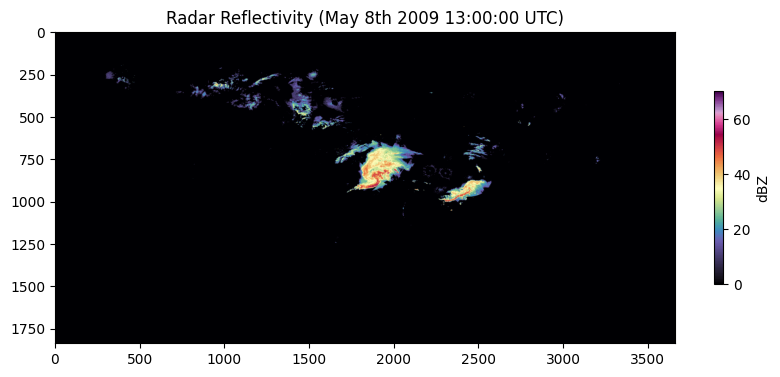

In [9]:
plt.rcParams['figure.figsize'] = 10, 10

img = Image.open("storm_mode/BREF_090508_1300.png")
img = np.array(img)

print(img.shape)

plt.imshow(np.array(img) * 5, cmap='ChaseSpectral')
plt.title("Radar Reflectivity (May 8th 2009 13:00:00 UTC)")
cbar = plt.colorbar(shrink=0.25)
cbar.set_label("dBZ")

The raw signal from this image is in 2 dimensions. We can turn this into a one dimensional signal like the previous examples using `flatten()` from `numpy`. This results in a feature vector with more than 6.7 million features. This can slow down processing and machine learning model training, even on the best computing resources. We will learn in later chapters how we can transform this into a more compact representation.

*Your turn*: Try different ways to reduce the size of this feature vector using basic numpy functions.

NOTE: because `int` is much smaller to save in a file, the radar image above is [quantized](https://en.wikipedia.org/wiki/Quantization_(image_processing)) to the nearest 5 `dBZ` and stored in `int` format, with values ranging from 0 to 16. The conversion to `dBZ` requires multiplying the value by 5.

Text(0, 0.5, 'dBZ')

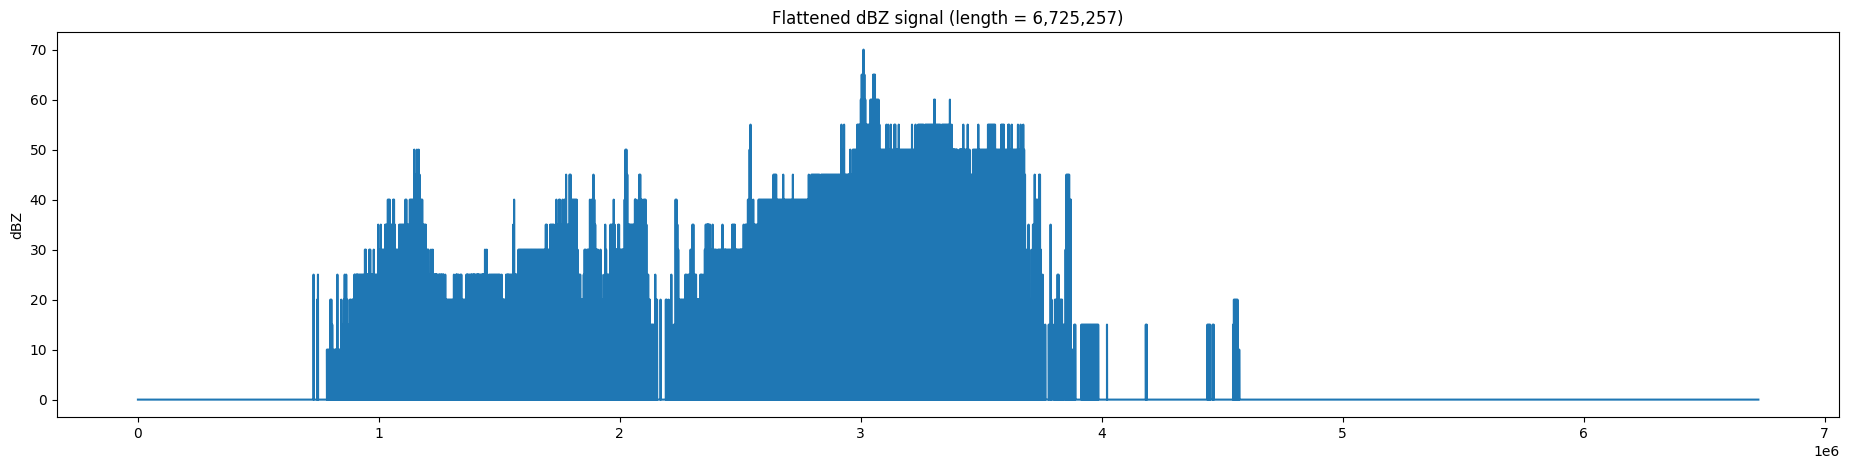

In [10]:
plt.rcParams['figure.figsize'] = (23, 5)

flat = img.flatten()

plt.plot(flat * 5, '-')

plt.title(f"Flattened dBZ signal (length = {len(flat):,})")
plt.ylabel('dBZ')